# Exercice 3 - Liquid Gaz Point from Virial Coefficients


## Q1 - Conditions de criticité

a) L'équation d'état du Viriel est donnée par:
$$
\frac{PV}{Nk_BT}=\sum_{l=1}^{\infty} a_l(\frac{\lambda^3}{v})^{l-1}
$$
où $v=\frac{V}{N}$ et on définit $\rho = \frac{N}{V}$ alors, à l'ordre 3, l'équation devient:
$$
\frac{PV}{N k_B T}
= \sum_{\ell = 1}^{\infty} a_\ell \left( \lambda^3\, \rho \right)^{\ell - 1}
\simeq 
a_1 
+ a_2 \lambda^3 \rho
+ a_3 \lambda^6 \rho^2 \\
\Longleftrightarrow \qquad
\frac{P}{k_B T}
\simeq
a_1 \rho
+ a_2 \lambda^3 \rho^2
+ a_3 \lambda^6 \rho^3
$$

b) La première et seconde dérivée sont:
$$
\partial_{\rho} \mathcal{L} 
= k_{B} T \left( a_{1} + 2 a_{2}\, \lambda^3 \,\rho + 3 a_{3}\,\lambda^6\,\rho^{2} \right) \\

\partial_{\rho}^{2} \mathcal{L}
= k_{B} T \left( 2\, \lambda^3\, a_{2} + 6\,\lambda^3\, a_{3}\,\rho \right)
$$

c) Les deux équations de criticité obtenues sont:
$$
1 + 2\,\lambda^3\, a_{2}(T_c)\,\rho_c + 3\,\lambda^6\, a_{3}(T_c)\,\rho^{2}_c  = 0 \qquad(*) \\
2 a_{2}(T_c) + 6\,\lambda^3\, a_{3}(T_c)\,\rho_c  = 0 \qquad(**)
$$




## Q2 - Condition reliant $a_2(T_c)$ et $a_3(T_c)$

A partir de l'équation $(**)$ on obtient $\rho_c = -\,\frac{2\,a_2(T_c)}{\lambda^3\,6\,a_3(T_c)}$ et en remplaçant cette variable dans $(*)$ nous avons:
$$
1 + 2\lambda^3 a_2(T_c)\!\left(-\,\frac{2 a_2(T_c)}{\lambda^3\,6\,a_3(T_c)}\right)
+ 3\lambda^6 a_3(T_c)\!\left(-\,\frac{2 a_2(T_c)}{\lambda^3\,6\,a_3(T_c)}\right)^{\!2}
= 0\\
\Rightarrow\quad
1 - \frac{2 a_2(T_c)^2}{3 a_3(T_c)}
+ \frac{3\lambda^6 a_3(T_c)\,4 a_2(T_c)^2}{\lambda^6\,36\,a_3(T_c)^2}
= 0\\
\Rightarrow\quad
1 - \frac{2 a_2(T_c)^2}{3 a_3(T_c)}
+ \frac{1}{3}\frac{a_2(T_c)^2}{a_3(T_c)}
= 0\\
\Rightarrow\quad
\frac{a_2(T_c)^2}{3} = a_3(T_c).
$$


## Q3 - Détermination du point critique

In [8]:
import sys, subprocess

# install common scientific packages
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "numpy", "matplotlib", "scipy", "seaborn", "pandas"])

0

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd
import random

In [10]:
kB = 1.0  
sigma = 1.0 
tau = 1.5 
epsilon = 2.0  
h = 1.0 
m = 1.0  
block_size = 1000  

def sample_in_sphere(Rc):
    '''
    Rc : rayon Rc
    Retourne : position aléatoire uniformément distribuée dans une sphère de rayon Rc
    '''
    u = random.uniform(0, 1)
    phi = random.uniform(0, 2*np.pi)
    cos_theta = random.uniform(-1, 1)  # Sampler cos(theta) uniformément pour distribution uniforme
    sin_theta = np.sqrt(1 - cos_theta**2)
    r = Rc * (u ** (1/3))
    pos = np.array([r * sin_theta * np.cos(phi), r * sin_theta * np.sin(phi), r * cos_theta])
    return pos

def Mayer_function(rij, T, sigma=sigma, tau=tau, epsilon=epsilon):
    '''
    rij : distance entre deux particules
    T : température
    Retourne : valeur de la fonction de Mayer
    '''
    if rij < sigma:
        return -1
    elif sigma <= rij < sigma * tau:
        return np.exp(epsilon / (kB * T)) - 1
    else:
        return 0
        
def estimate_a3(T, Rc, Ne, sigma=sigma, tau=tau, epsilon=epsilon):
    '''
    T : température
    Rc : rayon Rc
    Ne : nombre d'échantillons Monte Carlo
    Retourne : estimation de a3 et erreur statistique
    '''
    pos_part1 = np.zeros(3)

    if Ne % block_size != 0:
        raise ValueError("Ne doit être un multiple de block_size.")

    n_blocks = Ne // block_size
    block_means = np.zeros(n_blocks)

    for b in range(n_blocks):
        block_sum = 0.0
        for i in range(block_size):

            pos_part2 = sample_in_sphere(Rc)
            pos_part3 = sample_in_sphere(Rc)

            r12 = np.linalg.norm(pos_part1 - pos_part2)
            r13 = np.linalg.norm(pos_part1 - pos_part3)
            r23 = np.linalg.norm(pos_part2 - pos_part3)

            f12 = Mayer_function(r12, T)
            f13 = Mayer_function(r13, T)
            f23 = Mayer_function(r23, T)

            block_sum += f12 * f13 * f23

        block_means[b] = block_sum / block_size

    # Moyenne sur D
    mean_over_D = np.mean(block_means)

    # Erreur statistique 
    std_blocks = np.std(block_means, ddof=1)
    err_mean_over_D = std_blocks / np.sqrt(n_blocks)

    lambda_ = h / np.sqrt(2 * np.pi * m * kB * T)
    V_D = ((4/3) * np.pi * Rc**3)**2

    pref = -V_D / (3 * lambda_**6)
    a3 = pref * mean_over_D
    err_a3 = abs(pref) * err_mean_over_D

    return a3, err_a3

a) Le code suivant représente $\frac{a_2(T_c)^2}{3}$ et $ a_3(T_c)$ où $a_2=\frac{2\pi}{\lambda^3}\frac{\sigma^3}{3}(1-(e^{\beta \varepsilon}-1)(\tau^3-1))$ et $a_3 = -\frac{V_D}{3\lambda^6}\,\langle f_{12} f_{13} f_{23} \rangle_D$ qui est calculé numériquement. 

1)Calcul de a3 pour T=2.4 K...
2)Calcul de a3 pour T=2.406060606060606 K...
3)Calcul de a3 pour T=2.412121212121212 K...
4)Calcul de a3 pour T=2.418181818181818 K...
5)Calcul de a3 pour T=2.4242424242424243 K...
6)Calcul de a3 pour T=2.43030303030303 K...
7)Calcul de a3 pour T=2.436363636363636 K...
8)Calcul de a3 pour T=2.4424242424242424 K...
9)Calcul de a3 pour T=2.4484848484848483 K...
10)Calcul de a3 pour T=2.4545454545454546 K...
11)Calcul de a3 pour T=2.4606060606060605 K...
12)Calcul de a3 pour T=2.466666666666667 K...
13)Calcul de a3 pour T=2.4727272727272727 K...
14)Calcul de a3 pour T=2.4787878787878785 K...
15)Calcul de a3 pour T=2.484848484848485 K...
16)Calcul de a3 pour T=2.4909090909090907 K...
17)Calcul de a3 pour T=2.496969696969697 K...
18)Calcul de a3 pour T=2.503030303030303 K...
19)Calcul de a3 pour T=2.509090909090909 K...
20)Calcul de a3 pour T=2.515151515151515 K...
21)Calcul de a3 pour T=2.521212121212121 K...
22)Calcul de a3 pour T=2.5272727272727273 K...
23)

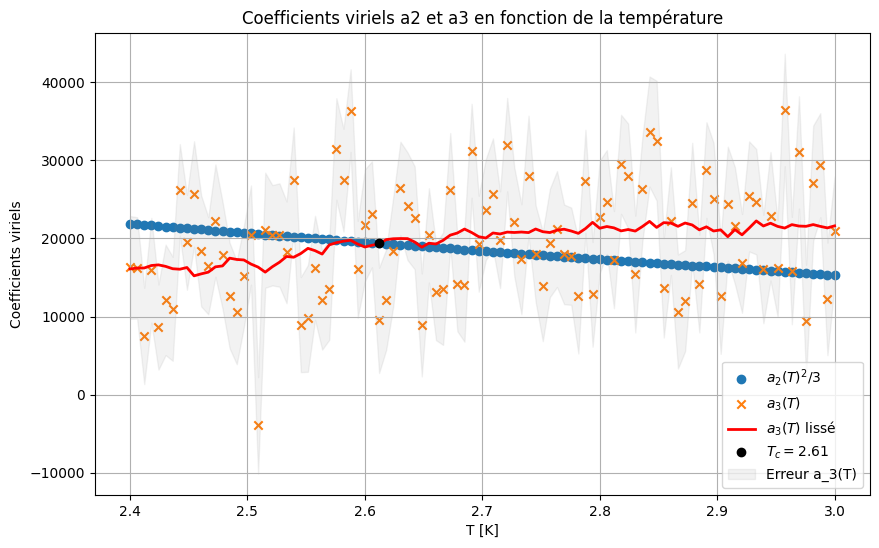

In [56]:
def moving_average(y, window=11):
    window = int(window)
    if window < 1:
        return y.copy()
    if window % 2 == 0:
        window += 1  # enforce odd window for symmetric smoothing
    pad = window // 2
    ypad = np.pad(y, (pad, pad), mode="edge")
    kernel = np.ones(window) / window
    return np.convolve(ypad, kernel, mode="valid")
def estimate_Tc(f, g, T):
    return T[np.argmin(abs(f - g))]
def a_2(T): 
    return 2*np.pi*sigma**3/3/(lambda_(T))**3*(1 - (tau**3 - 1)*(np.exp(epsilon/(kB*T))-1))
def lambda_(T):
    return h / np.sqrt(2 * np.pi * m * kB * T)

T = np.linspace(2.4, 3, 100)

a_3 = np.zeros((len(T), 2))

for i in range(len(T)):
    print(f"{i+1})Calcul de a3 pour T={T[i]} K...")
    a_3[i] = estimate_a3(T[i], Rc=3*sigma, Ne=100000)

a3_mean_smooth = moving_average(a_3[:,0], window=18)   

plt.figure(figsize=(10, 6))
plt.scatter(T, a_2(T)**(2)/3, label=r'$a_2(T)^{2}/3$', marker='o')
plt.scatter(T, a_3[:,0], label=r'$a_3(T)$', marker='x')
plt.plot(T, a3_mean_smooth, label=r'$a_3(T)$ lissé', color='red', linewidth=2)
Tc = estimate_Tc(a_2(T)**(2)/3, a3_mean_smooth, T)
print(f'Température critique estimée Tc = {Tc:.2f} K')
rho_c =1/(lambda_(Tc)**3*a_2(Tc))
print(rf'$\rho_c =${rho_c:.4f}')
print(rf'Pc = {kB * Tc * (rho_c + a_2(Tc) * (lambda_(Tc)**3) * rho_c**2+ (a_2(Tc)**2 / 3) * (lambda_(Tc)**6) * rho_c**3):.4f}')
plt.plot(Tc, a_2(Tc)**(2)/3, 'ko', label=rf'$T_c = {Tc:.2f}$')
plt.fill_between(T, a_3[:,0] - a_3[:,1], a_3[:,0] + a_3[:,1], color='gray', alpha=0.1, label='Erreur a_3(T)')
plt.xlabel('T [K]')
plt.ylabel('Coefficients viriels')
plt.title('Coefficients viriels a2 et a3 en fonction de la température')
plt.legend()
plt.grid()
plt.show()

b) A partir de l'équation de criticité $\qquad(**)$ nous pouvons trouver $\rho_c$:
$$ \rho_c  = \frac{2 a_{2}(T_c)}{6\,\lambda^3\, a_{3}(T_c)}=\frac{1}{\lambda^3\,a_2(T_c)} = REMPLIRE AVEC BONNE FONCTION A_3$$

c) Et la pression critique est donnée par:
$$
P_c
\simeq k_B T_c (a_1 \rho_c + a_2 \lambda^3 \rho_c^2 + a_3 \lambda^6 \rho_c^3)
= REMPLIREAVEC BONNE FONCTION A_3
$$

d) 